# 0. Download Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/kubig_ML/kubig_ML_contest/jeju.zip

Archive:  drive/MyDrive/kubig_ML/kubig_ML_contest/jeju.zip
replace open/data_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace open/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace open/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace open/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import pandas as pd
data_info=pd.read_csv('open/data_info.csv')
train=pd.read_csv('open/train.csv')
test=pd.read_csv('open/test.csv')

In [5]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [6]:
csv_to_parquet('open/train.csv', 'train')
csv_to_parquet('open/test.csv', 'test')

train Done.
test Done.


In [7]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [8]:
train_prep=train.copy()
test_prep=test.copy()

In [9]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [10]:
train[train.drop(columns=['id','target']).duplicated()]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target


# Preprocessing

## 불필요한 변수 제거

In [11]:
train_prep.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)
test_prep.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)

## 'base_date' 처리
'day' : drop

In [12]:
# 날짜
# 연/일/월 파생변수 생성
train_prep["base_date"] = pd.to_datetime(train_prep["base_date"],format='%Y%m%d')
train_prep['year']= train_prep['base_date'].dt.year     # 데이터를 2021, 2022 구분
train_prep['month']= train_prep['base_date'].dt.month   # 데이터를 월별로 구분(4, 8월 데이터 없음)
train_prep['day']= train_prep['base_date'].dt.day       # 데이터를 일자(31일)별로 구분

In [13]:
# 날짜
# 연/일/월 파생변수 생성
test_prep["base_date"] = pd.to_datetime(test_prep["base_date"],format='%Y%m%d')
test_prep['year']= test_prep['base_date'].dt.year     # 데이터를 2021, 2022 구분
test_prep['month']= test_prep['base_date'].dt.month   # 데이터를 월별로 구분(4, 8월 데이터 없음)
test_prep['day']= test_prep['base_date'].dt.day       # 데이터를 일자(31일)별로 구분

In [14]:
train_prep=train_prep.drop(columns="base_date")
test_prep=test_prep.drop(columns="base_date")

## 'start_turn_restricted', 'end_turn_restricted' : 0,1로 encoding

In [15]:
train_prep['start_turn_restricted']=train_prep['start_turn_restricted'].replace(['있음','없음'],[1,0])
train_prep['end_turn_restricted']=train_prep['end_turn_restricted'].replace(['있음','없음'],[1,0])

In [16]:
test_prep['start_turn_restricted']=test_prep['start_turn_restricted'].replace(['있음','없음'],[1,0])
test_prep['end_turn_restricted']=test_prep['end_turn_restricted'].replace(['있음','없음'],[1,0])

## 파생변수 : 공휴일 변수 'holiday' 추가

In [17]:
# 공휴일 파생변수(외부 데이터)
holiday = pd.read_csv('drive/MyDrive/kubig_ML/kubig_ML_contest/holiday.csv')
holiday.head()

,year,month,day,is_holiday
0,2021,1,1,1
1,2021,2,11,1
2,2021,2,12,1
3,2021,2,13,1
4,2021,3,1,1


In [18]:
# holiday df와 train df 합쳐주기
train_prep = train_prep.merge(holiday[['year', 'month', 'day','is_holiday']], how='left', on=['year', 'month','day'])
train_prep['is_holiday']=train_prep['is_holiday'].fillna(0)
train_prep

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,day,is_holiday
0,목,17,1,106,지방도1112호선,0,0,60.0,32400.0,3,...,0,제3교래교,33.427749,126.662335,0,52.0,2022,6,23,0.0
1,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0,...,1,KAL사거리,33.504811,126.526240,0,30.0,2022,7,28,0.0
2,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0,...,0,상창육교,33.280072,126.362147,0,61.0,2021,10,10,0.0
3,금,13,2,107,태평로,0,0,50.0,0.0,0,...,0,서현주택,33.245565,126.566228,0,20.0,2022,3,11,0.0
4,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0,...,0,애월입구,33.462677,126.330152,0,38.0,2021,10,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,목,16,1,107,-,0,0,50.0,0.0,0,...,0,금덕해운,33.420955,126.273750,0,20.0,2021,11,4,0.0
4701213,목,2,2,107,-,0,0,80.0,43200.0,3,...,0,광삼교,33.472525,126.424890,0,65.0,2022,3,31,0.0
4701214,월,22,2,103,일반국도12호선,0,0,60.0,0.0,0,...,0,성산교차로,33.444121,126.912948,0,30.0,2022,6,13,0.0
4701215,수,2,2,103,일반국도95호선,0,0,80.0,0.0,0,...,0,관광대학입구,33.444996,126.433332,0,73.0,2021,10,20,0.0


In [19]:
# 주말 여부 - 다중공선성?
def create_time_features(data):

    tmp = data.copy()

    tmp['weekend'] = tmp['day_of_week'].map({"월":0, "화":0, "수":0, "목":0, "금":0, "토":1, "일":1})

    tmp['holiday'] = (tmp['weekend'] + tmp['is_holiday']).map({0:0, 1:1, 2:1})
    tmp = tmp.drop(['weekend', 'is_holiday'], axis=1)

    return tmp

train_prep = create_time_features(train_prep)

In [20]:
# test data에 적용
test_prep = test_prep.merge(holiday[['year', 'month', 'day','is_holiday']], how='left', on=['year', 'month','day'])
test_prep['is_holiday']=test_prep['is_holiday'].fillna(0)

In [21]:
test_prep = create_time_features(test_prep)

In [22]:
# 관광객 입도 현황(외부 데이터 추가)
tourist = pd.read_csv('drive/MyDrive/kubig_ML/kubig_ML_contest/tourist_int.csv')
tourist

,year,month,tourist
0,2021,1,468016
1,2021,2,793768
2,2021,3,893326
3,2021,4,1082861
4,2021,5,1136452
5,2021,6,1138867
6,2021,7,1131512
7,2021,8,974194
8,2021,9,872396
9,2021,10,1222094


In [23]:
# 위 tourist df를 train df와 합쳐줌
train_prep = train_prep.merge(tourist[['year', 'month', 'tourist']], how='left', on=['year', 'month'])
train_prep

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,day,holiday,tourist
0,목,17,1,106,지방도1112호선,0,0,60.0,32400.0,3,...,제3교래교,33.427749,126.662335,0,52.0,2022,6,23,0,1283470
1,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0,...,KAL사거리,33.504811,126.526240,0,30.0,2022,7,28,0,1263332
2,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0,...,상창육교,33.280072,126.362147,0,61.0,2021,10,10,1,1222094
3,금,13,2,107,태평로,0,0,50.0,0.0,0,...,서현주택,33.245565,126.566228,0,20.0,2022,3,11,0,873086
4,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0,...,애월입구,33.462677,126.330152,0,38.0,2021,10,5,0,1222094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,목,16,1,107,-,0,0,50.0,0.0,0,...,금덕해운,33.420955,126.273750,0,20.0,2021,11,4,0,1204344
4701213,목,2,2,107,-,0,0,80.0,43200.0,3,...,광삼교,33.472525,126.424890,0,65.0,2022,3,31,0,873086
4701214,월,22,2,103,일반국도12호선,0,0,60.0,0.0,0,...,성산교차로,33.444121,126.912948,0,30.0,2022,6,13,0,1283470
4701215,수,2,2,103,일반국도95호선,0,0,80.0,0.0,0,...,관광대학입구,33.444996,126.433332,0,73.0,2021,10,20,0,1222094


In [24]:
# test data는 모두 2022년 8월이므로 1,281,608로 채워줌
test_prep['tourist']=1281608

In [25]:
train_prep=train_prep.drop(columns='day')
test_prep=test_prep.drop(columns='day')


## 'road_name' ,'start_node', 'end_node' : label encoding

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

#fig, axis = plt.subplots(1, figsize=(15,30))
#sns.lineplot(x='year',y='target',hue='road_name',data=train_prep,legend=False).set(title='year vs target')

In [27]:
from sklearn.preprocessing import LabelEncoder

items =  ['road_name', 'start_node_name','end_node_name']
encoder = LabelEncoder()

for i in items:
    encoder.fit(train_prep[i])
    train_prep[i] = encoder.transform(train_prep[i])
    test_prep[i]=encoder.transform(test_prep[i])


## 'day_of_week' : 0,1,2,3,4,5,6 으로 encoding

In [28]:
train_prep['day_of_week']=train_prep['day_of_week'].map({"수":0,"목":1,"금":2,"토":3,"일":4,"월":5,"화":6})
test_prep['day_of_week']=test_prep['day_of_week'].map({"수":0,"목":1,"금":2,"토":3,"일":4,"월":5,"화":6})

## 'start_longitude', 'start_latitude', 'end_longitude', 'end_latitude' :
좌표축 이동 후 16개로 구간 나눔 -> district_start , district_end 파생변수

In [29]:
train_prep['end_longitude']=train['end_longitude'].copy()
train_prep['end_latitude']=train['end_latitude'].copy()

In [30]:
end_long_min=min(train_prep['end_longitude'])
end_lat_min=min(train_prep['end_latitude'])

In [31]:
train_prep['end_longitude']=train_prep['end_longitude']-end_long_min
train_prep['end_latitude']=train_prep['end_latitude']-end_lat_min

In [32]:
import math
degree=-15
rad = degree * (math.pi / 180.0)
train_prep['end_longitude'] = math.cos(rad)*train_prep['end_longitude'] - math.sin(rad)*train_prep['end_latitude']
train_prep['end_latitude'] = math.sin(rad)*train_prep['end_longitude'] + math.cos(rad)*train_prep['end_latitude']

In [33]:
train_prep['end_longitude']=train_prep['end_longitude']+end_long_min
train_prep['end_latitude']=train_prep['end_latitude']+end_lat_min

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


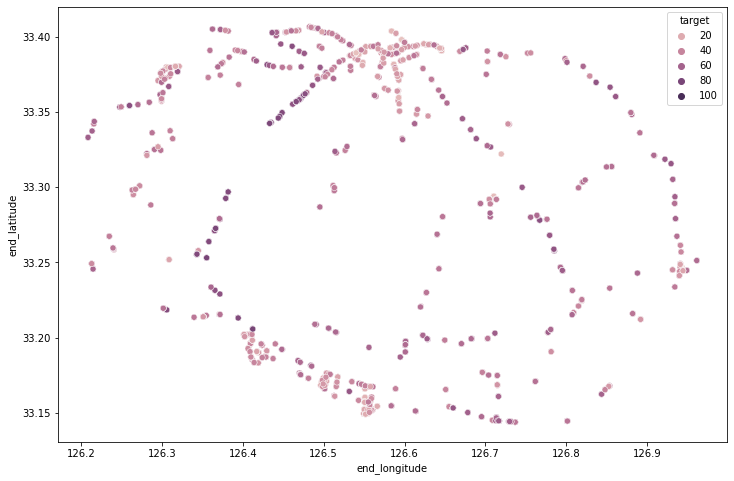

In [34]:
# 해안도로 여부  > 논의 필요
# plot_dims=(12,8)
# plt.figure(figsize=plot_dims)
# sns.scatterplot(train_prep.end_longitude, train_prep.end_latitude, hue=train_prep.target)
# plt.ioff()

In [35]:
x_q1=train_prep['end_longitude'].quantile(.25)
x_q2=train_prep['end_longitude'].quantile(.5)
x_q3=train_prep['end_longitude'].quantile(.75)

y_q1=train_prep['end_latitude'].quantile(.25)
y_q2=train_prep['end_latitude'].quantile(.5)
y_q3=train_prep['end_latitude'].quantile(.75)

In [36]:
print(x_q1,x_q2,x_q3)
print(y_q1,y_q2,y_q3)

126.44881195950214 126.53478928087299 126.62267380596973
33.187185069472555 33.29500177064386 33.37977904156573


In [37]:
def district(x,y):
  if(x<x_q1):
    if(y<y_q1): return 1
    if((y>=y_q1) & (y<y_q2)): return 2
    if((y>=y_q2)&(y<y_q3)): return 3
    if(y>=y_q3): return 4

  elif((x>=x_q1) & (x<x_q2)):
    if(y<y_q1): return 5
    if((y>=y_q1) & (y<y_q2)): return 6
    if((y>=y_q2)&(y<y_q3)): return 7
    if(y>=y_q3): return 8

  elif((x>=x_q2) & (x<x_q3)):
    if(y<y_q1): return 9
    if((y>=y_q1) & (y<y_q2)): return 10
    if((y>=y_q2)&(y<y_q3)): return 11
    if(y>=y_q3): return 12

  else:
    if(y<y_q1): return 13
    if((y>=y_q1) & (y<y_q2)): return 14
    if((y>=y_q2)&(y<y_q3)): return 15
    if(y>=y_q3): return 16

In [38]:
district_end=[]

In [39]:
for index, row in train_prep.iterrows():
  district_end.append(district(row['end_longitude'],row['end_latitude']))

In [40]:
train_prep['district_end']=pd.DataFrame(district_end)

In [41]:
# train_prep['start_longitude']=train['start_longitude'].copy()
# train_prep['start_latitude']=train['start_latitude'].copy()

In [42]:
start_long_min=min(train_prep['start_longitude'])
start_lat_min=min(train_prep['start_latitude'])

In [43]:
train_prep['start_longitude']=train_prep['start_longitude']-start_long_min
train_prep['start_latitude']=train_prep['start_latitude']-start_lat_min

In [44]:
degree=-15
rad = degree * (math.pi / 180.0)
train_prep['start_longitude'] = math.cos(rad)*train_prep['start_longitude'] - math.sin(rad)*train_prep['start_latitude']
train_prep['start_latitude'] = math.sin(rad)*train_prep['start_longitude'] + math.cos(rad)*train_prep['start_latitude']

In [45]:
train_prep['start_longitude']=train_prep['start_longitude']+start_long_min
train_prep['start_latitude']=train_prep['start_latitude']+start_lat_min

In [46]:
# x_q1=train_prep['start_longitude'].quantile(.25)
# x_q2=train_prep['start_longitude'].quantile(.5)
# x_q3=train_prep['start_longitude'].quantile(.75)

# y_q1=train_prep['start_latitude'].quantile(.25)
# y_q2=train_prep['start_latitude'].quantile(.5)
# y_q3=train_prep['start_latitude'].quantile(.75)

In [47]:
# district_start=[]

In [48]:
# for index, row in train_prep.iterrows():
#   district_start.append(district(row['start_longitude'],row['start_latitude']))

In [49]:
# train_prep['district_start']=pd.DataFrame(district_start)

### test data에도 적용

In [50]:
# test_prep['end_longitude']=test['end_longitude'].copy()
# test_prep['end_latitude']=test['end_latitude'].copy()

In [51]:
test_prep['end_longitude']=test_prep['end_longitude']-min(test_prep['end_longitude'])
test_prep['end_latitude']=test_prep['end_latitude']-min(test_prep['end_latitude'])

In [52]:
degree=-15
rad = degree * (math.pi / 180.0)
test_prep['end_longitude'] = math.cos(rad)*test_prep['end_longitude'] - math.sin(rad)*test_prep['end_latitude']
test_prep['end_latitude'] = math.sin(rad)*test_prep['end_longitude'] + math.cos(rad)*test_prep['end_latitude']

In [53]:
test_prep['end_longitude']=test_prep['end_longitude']+min(test['end_longitude'])
test_prep['end_latitude']=test_prep['end_latitude']-+min(test['end_latitude'])

In [54]:
x_q1=test_prep['end_longitude'].quantile(.25)
x_q2=test_prep['end_longitude'].quantile(.5)
x_q3=test_prep['end_longitude'].quantile(.75)

y_q1=test_prep['end_latitude'].quantile(.25)
y_q2=test_prep['end_latitude'].quantile(.5)
y_q3=test_prep['end_latitude'].quantile(.75)

In [55]:
print(x_q1,x_q2,x_q3)
print(y_q1,y_q2,y_q3)

126.50278252343766 126.54638557896884 126.5880227513272
-33.28571439587727 -33.252765724687556 -33.07203082659145


In [56]:
district_end_y=[]

In [57]:
for index, row in test_prep.iterrows():
  district_end_y.append(district(row['end_longitude'],row['end_latitude']))

In [58]:
test_prep['district_end']=pd.DataFrame(district_end_y)

In [59]:
test_prep['start_longitude']=test_prep['start_longitude']-min(test_prep['start_longitude'])
test_prep['start_latitude']=test_prep['start_latitude']-min(test_prep['start_latitude'])

In [60]:
degree=-15
rad = degree * (math.pi / 180.0)
test_prep['start_longitude'] = math.cos(rad)*test_prep['start_longitude'] - math.sin(rad)*test_prep['start_latitude']
test_prep['start_latitude'] = math.sin(rad)*test_prep['start_longitude'] + math.cos(rad)*test_prep['start_latitude']

In [61]:
test_prep['start_longitude']=test_prep['start_longitude']+min(test['start_longitude'])
test_prep['start_latitude']=test_prep['start_latitude']+min(test['start_latitude'])

In [62]:
# x_q1=test_prep['start_longitude'].quantile(.25)
# x_q2=test_prep['start_longitude'].quantile(.5)
# x_q3=test_prep['start_longitude'].quantile(.75)

# y_q1=test_prep['start_latitude'].quantile(.25)
# y_q2=test_prep['start_latitude'].quantile(.5)
# y_q3=test_prep['start_latitude'].quantile(.75)

In [63]:
# district_start_y=[]

In [64]:
# for index, row in test_prep.iterrows():
#   district_start_y.append(district(row['start_longitude'],row['start_latitude']))

In [65]:
# test_prep['district_start']=pd.DataFrame(district_start_y)

##'road_type' : drop

In [66]:
# train_prep['road_type']=train['road_type'].copy()
# test_prep['road_type']=test['road_type'].copy()

In [67]:
# train_prep=train_prep.drop(columns='road_type')
# test_prep=test_prep.drop(columns='road_type')

# train test split을 통한 검증

In [77]:
X=train_prep.drop(columns='target')
y=train_prep['target']

In [69]:
X

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,year,month,holiday,tourist,district_end
0,1,17,1,106,46,0,0,60.0,32400.0,3,...,0,386,33.289192,126.693694,0,2022,6,0,1283470,14
1,1,21,2,103,34,0,0,60.0,0.0,0,...,1,2,33.392490,126.582181,0,2022,7,0,1263332,12
2,4,7,2,103,36,0,0,80.0,0.0,0,...,0,179,33.231486,126.365513,0,2021,10,1,1222094,2
3,2,13,2,107,57,0,0,50.0,0.0,0,...,0,203,33.149447,126.553709,0,2022,3,0,873086,9
4,6,8,2,103,35,0,0,80.0,0.0,0,...,0,269,33.403636,126.381869,0,2021,10,0,1222094,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,1,16,1,107,0,0,0,50.0,0.0,0,...,0,42,33.380231,126.316591,0,2021,11,0,1204344,4
4701213,1,2,2,107,0,0,0,80.0,43200.0,3,...,0,31,33.388804,126.475929,0,2022,3,0,873086,8
4701214,5,22,2,103,35,0,0,60.0,0.0,0,...,0,214,33.241256,126.940004,0,2022,6,0,1283470,14
4701215,0,2,2,103,37,0,0,80.0,0.0,0,...,0,23,33.361947,126.476957,0,2021,10,0,1222094,7


In [78]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
X_train,X_val,y_train,y_val=train_test_split(X,y,
                                               test_size=0.3, 
                                               shuffle=False, 
                                               random_state=2023
                                               )

model_lgbmR=LGBMRegressor(random_state=2023)
model_lgbmR.fit(X_train,y_train)

y_pred=model_lgbmR.predict(X_val)
mae(y_val,y_pred)


4.651299145474926

* base 모델 결과: 4.699195527102074
* end 구간 추가: 4.649629707239353
* start 구간 추가: 4.631140300370354
* 'day' drop: 4.614508555025936

# 제출 파일

In [71]:
X_test=test_prep

model=LGBMRegressor(random_state=2023)
model.fit(X,y)
pred=model.predict(X_test)

In [74]:
submission_base=pd.DataFrame(pred,columns=['target'])
submission_base=pd.concat([test['id'],submission_base],axis=1)
submission_base.to_csv("submission_base5.csv",index = False)

In [75]:
submission_base

,id,target
0,TEST_000000,27.353713
1,TEST_000001,39.782192
2,TEST_000002,55.579813
3,TEST_000003,45.512948
4,TEST_000004,38.898982
...,...,...
291236,TEST_291236,48.008724
291237,TEST_291237,48.864166
291238,TEST_291238,20.941098
291239,TEST_291239,27.718152
